In [1]:
import logging
from argparse import ArgumentParser

import torch
import torch.nn.functional as F
import wandb
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader
from tqdm import trange

from experiments.data import INRDataset
from experiments.utils import (
    common_parser,
    count_parameters,
    get_device,
    set_logger,
    set_seed,
    str2bool,
)
from nn.models import DWSModelForClassification, MLPModelForClassification

from experiments.mnist.generate_data_splits import generate_splits
from experiments.mnist.compute_statistics import compute_stats

set_logger()

In [2]:
path = "DWSNets/dataset/mnist_splits.json" # data_path = 
statistics_path = "DWSNets/dataset/statistics.pth" # data_path = 
normalize = True
augmentation = True

batch_size = 32
num_workers = 4

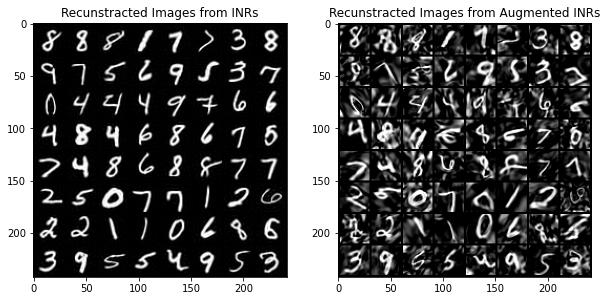

In [3]:
from torchvision.utils import save_image, make_grid
import torch

from experiments.data import INRImageDataset
from experiments.utils import set_seed
import matplotlib.pyplot as plt

# Create non-augmented INRImage Dataset
dataset = INRImageDataset(
    path=path,  # path to splits json file
    augmentation=False,
    split="train",
)
loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)

# Create augmented INRImage Dataset
dataset_aug = INRImageDataset(
    path=path,  # path to splits json file
    augmentation=True,
    split="train",
)
loader_aug = torch.utils.data.DataLoader(dataset_aug, batch_size=64, shuffle=False)


batch = next(iter(loader))
batch_aug = next(iter(loader_aug))


fig, axs = plt.subplots(1, 2, figsize=(10,20)) 

axs[0].imshow(make_grid(batch.image.squeeze(-1)).permute(1, 2, 0).clip(0, 1))
axs[0].set_title('Recunstracted Images from INRs')

axs[1].imshow(make_grid(batch_aug.image.squeeze(-1)).permute(1, 2, 0).clip(0, 1))
axs[1].set_title('Recunstracted Images from Augmented INRs')
plt.show()


In [4]:
train_set = INRDataset(
        path=path,
        split="train",
        normalize=normalize,
        augmentation=augmentation,
        statistics_path=statistics_path,
    ) # create dataset for the training set (seen in training)

val_set = INRDataset(
    path=path,
    split="val",
    normalize=normalize,
    statistics_path=statistics_path,
) # create dataset for the validation set (seen in training)

test_set = INRDataset(
    path=path,
    split="test",
    normalize=normalize,
    statistics_path=statistics_path,
) # create dataset for the test set (not seen in training)


# Now make torch dataloaders for those datasets
train_loader = torch.utils.data.DataLoader(
        dataset=train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
)

# Keeping track of stuff
logging.info(
    f"train size {len(train_set)}, "
    f"val size {len(val_set)}, "
    f"test size {len(test_set)}"
)

# Try running the DWSNet on augmented INRs like displayed and not the raw ones like it does stock

/home/biggs.s/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
2024-09-09 15:59:13,320 - root - INFO - train size 55000, val size 5000, test size 10000


In [6]:
# get device
device = get_device()
logging.info(f"device = {device}")

point = train_set.__getitem__(0)
# shapes to initialize the DWSNet
weight_shapes = tuple(w.shape[:2] for w in point.weights)
bias_shapes = tuple(b.shape[:1] for b in point.biases)

2024-09-09 16:00:05,267 - root - INFO - device = cpu


In [7]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    loss = 0.0
    correct = 0.0
    total = 0.0
    predicted, gt = [], []
    for batch in loader:
        batch = batch.to(device)
        inputs = (batch.weights, batch.biases)
        out = model(inputs)
        loss += F.cross_entropy(out, batch.label, reduction="sum")
        total += len(batch.label)
        pred = out.argmax(1) # The softmax by proxy 'hard'max XD  
        correct += pred.eq(batch.label).sum()
        predicted.extend(pred.cpu().numpy().tolist())
        gt.extend(batch.label.cpu().numpy().tolist())

    model.train()
    avg_loss = loss / total
    avg_acc = correct / total

    return dict(avg_loss=avg_loss, avg_acc=avg_acc, predicted=predicted, gt=gt)

In [8]:
import matplotlib.pyplot as plt
import random
import numpy as np

def reset_seed():
    np.random.seed( 999 )
    random.seed( 999 )
    torch.manual_seed( 999 )


In [9]:
# Removed: 
# - Test set stats per epoch
def Train(model, train_loader, epochs):
    optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-3, amsgrad=True, weight_decay=5e-4)
    
    epoch_iter = trange(epochs)
    criterion = nn.CrossEntropyLoss()
    test_acc = -1
    
    losses = []
    sums = []
    j = 0
    
    for epoch in epoch_iter:
        for i, batch in enumerate(train_loader):
            j = j + 1
            
            model.train()
            optimizer.zero_grad()

            batch = batch.to(device)
            inputs = (batch.weights, batch.biases)
            

# To-Do: Make some working logic here so I don't have to manually fix it
#             out, x = model(inputs)
            out = model(inputs)
                        
            
            loss = criterion(out, batch.label)
            loss.backward()
            optimizer.step()
            
            losses.append( loss.item() )
            epoch_iter.set_description(f"[{epoch} {i+1}], train loss: {loss.item():.3f}")
            
#         if (epoch+1)%3 == 0: 
#             print(x)
            
    plt.plot( np.linspace(0, j, j, endpoint = True), losses, color = 'r')
    

In [10]:
from typing import Tuple

import torch
from torch import nn

from nn.layers import BN, DownSampleDWSLayer, Dropout, DWSLayer, InvariantLayer, ReLU

In [11]:
# from typing import Tuple
# from nn.layers import BN, DownSampleDWSLayer, Dropout, DWSLayer, InvariantLayer, LeakyReLU

# Removed Downsample DWS Layers & Logic
# Swapped Leaky ReLU for regular ReLU b/c reproducibility

class SimpleEncoder(nn.Module):
    def __init__(
            self,
            weight_shapes,
            bias_shapes,
            input_features,
            hidden_dims,
            output_features,
            n_hidden=2, # Was 8, change to 2 bc thats what it is in the demo 
            reduction="max",
            bias=True,
            n_fc_layers=1,
            num_heads=4,
            set_layer="sab",
            add_layer_skip = False,
            input_dim_downsample=None,
            dropout_rate=0.0,
            init_scale=1e-4,
            init_off_diag_scale_penalty=1.,
            bn=False,
            diagonal=False,
    ):
        super().__init__()
        assert len(weight_shapes) > 2, "the current implementation only support input networks with M>2 layers."
        assert len(hidden_dims) == n_hidden ,"hidden dims length must be equal to the number of hidden dimensions"

        layers = [
            DWSLayer(
                weight_shapes=weight_shapes,
                bias_shapes=bias_shapes,
                in_features=input_features,
                out_features=hidden_dims[0],
                reduction=reduction,
                bias=bias,
                n_fc_layers=n_fc_layers,
                num_heads=num_heads,
                set_layer=set_layer,
                add_skip=add_layer_skip,
                init_scale=init_scale,
                init_off_diag_scale_penalty=init_off_diag_scale_penalty,
                diagonal=diagonal,
            ),
        ]
        for i in range(n_hidden-1):
            if bn:
                layers.append(BN(hidden_dims[i], len(weight_shapes), len(bias_shapes)))

            layers.extend(
                [

#                     LeakyReLU(),
                    ReLU(),
                    Dropout(dropout_rate),
                    DWSLayer(
                        weight_shapes=weight_shapes,
                        bias_shapes=bias_shapes,
                        in_features=hidden_dims[i],
                        out_features=hidden_dims[i+1],
                        reduction=reduction,
                        bias=bias,
                        n_fc_layers=n_fc_layers,
                        num_heads=num_heads,
                        set_layer=set_layer,
                        add_skip=add_layer_skip,
                        init_scale=init_scale,
                        init_off_diag_scale_penalty=init_off_diag_scale_penalty,
                        diagonal=diagonal,
                    ),
                ]
            )
               
        if bn:
            layers.append(BN(hidden_dims[-1], len(weight_shapes), len(bias_shapes)))
        
        layers.extend(
            [
#                 LeakyReLU(),
                ReLU(),
                Dropout(dropout_rate),
                InvariantLayer(
                    weight_shapes=weight_shapes,
                    bias_shapes=bias_shapes,
                    in_features= hidden_dims[-1],
                    out_features= output_features,
                    reduction=reduction,
                    n_fc_layers=1, # was 3, but 1 is the same as the demo
                    ),
                ]
            )

        self.layers = nn.Sequential(*layers)

    def forward(self, x: Tuple[Tuple[torch.tensor], Tuple[torch.tensor]]):
        out = self.layers(x)
        return out

In [12]:
hidden_dims = [32, 16, 8, 8]
n_hidden = len( hidden_dims )
model3 = SimpleEncoder(
    weight_shapes = weight_shapes, # Dont change these - they make sense 
    bias_shapes = bias_shapes,
    input_features = 1, # 1 because the network is looking for 1 feature per input?
    hidden_dims = hidden_dims, # 32
    output_features = 10, 
    n_hidden = n_hidden,
    bn = True, # True - Maybe turn them off? 
).to(device)

[0 157], train loss: 1.435: 100%|██████████| 1/1 [00:59<00:00, 59.51s/it]


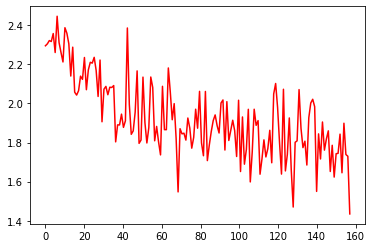

In [13]:
Train(model3, val_loader, 1) # trying the val loader bc it's smaller/faster 
